# Lab 2 Samuel Bieberich

In [40]:
#imports

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

## 1. Signal to Noise Ratio


### Generate a tone with frequency 2 MHz and amplitude 1 V. Sample the tone at frequencies Fs = 5 MHz.


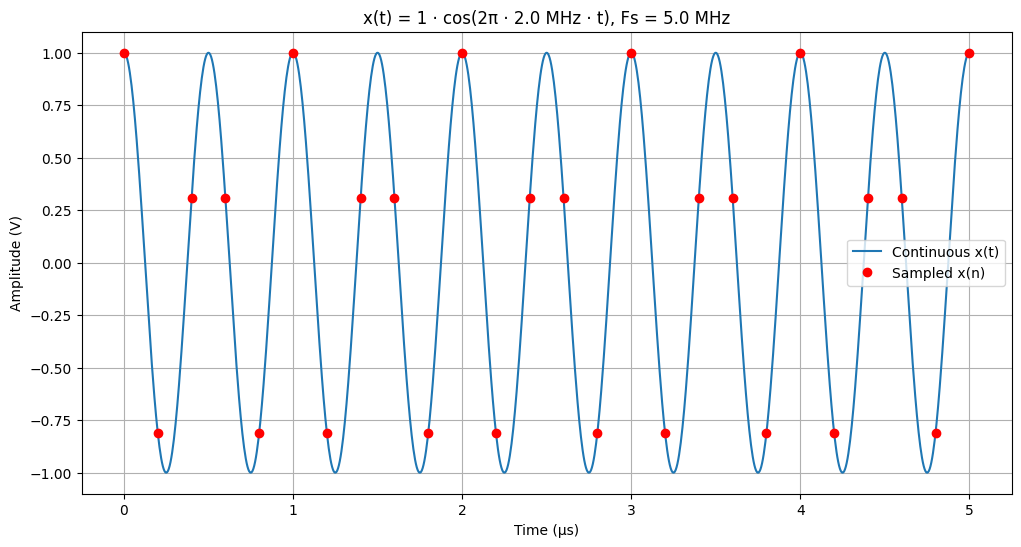

In [41]:
F = 2e6  
Fs = 5e6  
A = 1    

t = np.linspace(0, 5e-6, 1000) 

x = A * np.cos(2 * np.pi * F * t)

n = np.arange(0, 26) #12 is sample number 
ts = n / Fs

xs = A * np.cos(2 * np.pi * F * ts)

plt.figure(figsize=(12, 6))

plt.plot(t*1e6, x, label='Continuous x(t)')
plt.plot(ts*1e6, xs, 'ro', label='Sampled x(n)')
plt.title(f'x(t) = {A} · cos(2π · {F/1e6} MHz · t), Fs = {Fs/1e6} MHz')
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)

plt.show()


### (a) Add Gaussian noise
- Add Gaussian noise to the sampled sinewave such that the signal SNR is 50 dB.
- Find first the variance of the Gaussian noise needed to produce the target SNR.
- Calculate and plot the Power Spectral Density (PSD) from the DFT of the noisy samples.
- Corroborate that the SNR calculation from the DFT plot gives the theoretical result.
- What would be the variance of a uniformly distributed noise to obtain the same SNR?

In [42]:
signal_power = np.mean(xs ** 2)

snr_target_db = 50  #will not be exact due to the noise being relatively random

#db to linear to make it easier
snr_linear = 10 ** (snr_target_db / 10)

noise_power = signal_power / snr_linear

noise_variance = noise_power

print("The variance of the Gaussian noise needed to produce the target SNR is:", noise_variance)

The variance of the Gaussian noise needed to produce the target SNR is: 5.19230769230769e-06


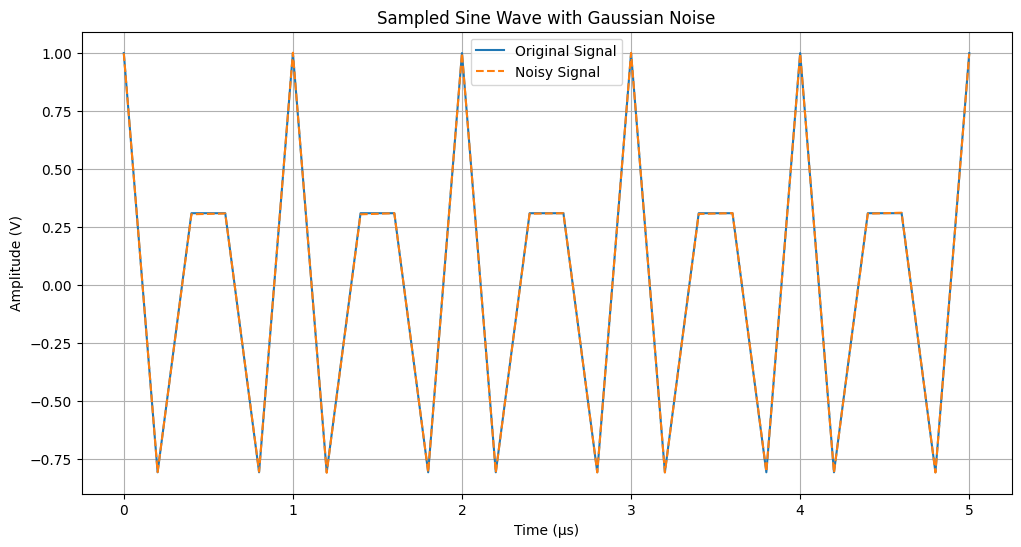

In [43]:
def add_gaussian_noise(signal, snr_db):
    """
    Add Gaussian noise to a signal to achieve a specified SNR in dB.
    
    Parameters:
    signal (numpy.ndarray): The original signal.
    snr_db (float): The desired Signal-to-Noise Ratio in decibels.
    
    Returns:
    numpy.ndarray: The noisy signal.
    """
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)
    noise = np.random.normal(0, noise_std, signal.shape)
    noisy_signal = signal + noise
    return noisy_signal

noisy_signal = add_gaussian_noise(xs, snr_target_db)

plt.figure(figsize=(12, 6))
plt.plot(ts * 1e6, xs, label='Original Signal')
plt.plot(ts * 1e6, noisy_signal, label='Noisy Signal', linestyle='--')
plt.title('Sampled Sine Wave with Gaussian Noise')
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)
plt.show()

SNR is 51.10047797564857 dB


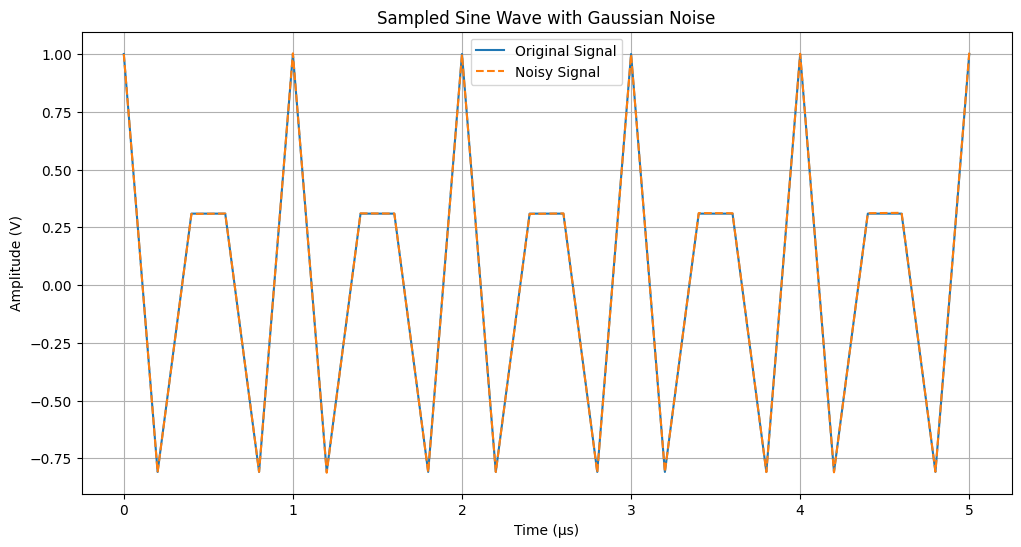

In [44]:
def compute_snr_db(signal, noisy_signal):
    """
    Compute the Signal-to-Noise Ratio (SNR) in decibels.
    
    Parameters:
    signal (numpy.ndarray): The original signal.
    noisy_signal (numpy.ndarray): The noisy signal.
    
    Returns:
    float: The SNR in decibels.
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean((signal - noisy_signal) ** 2)
    snr_linear = signal_power / noise_power
    snr_db = 10 * np.log10(snr_linear)
    return snr_db

noisy_signal = add_gaussian_noise(xs, snr_target_db)

snr_db = compute_snr_db(xs, noisy_signal)
print("SNR is", snr_db, "dB")

plt.figure(figsize=(12, 6))
plt.plot(ts * 1e6, xs, label='Original Signal')
plt.plot(ts * 1e6, noisy_signal, label='Noisy Signal', linestyle='--')
plt.title('Sampled Sine Wave with Gaussian Noise')
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)
plt.show()

### (b) Apply a window before DFT
- Repeat part (a) using the following windows: Hanning, Hamming, Blackman.
- What are your conclusions?
- **NOTE:** The use of windows mentioned above spreads the signal power. You must take this into account when computing SNR.

## 2. Quantization

### (a) Create a perfect quantizer with 6 bits of resolution and flexible sampling rate
- For a 200 MHz full-scale input tone, sample and quantize the sinewave at 400 MHz.
- Plot the PSD of 30 periods.
- What is the SNR?
- Repeat the SNR calculation for 100 periods of the same signal.
- Make conclusions about periodicity of quantization noise and its impact on SNR.
- How can you solve this problem?


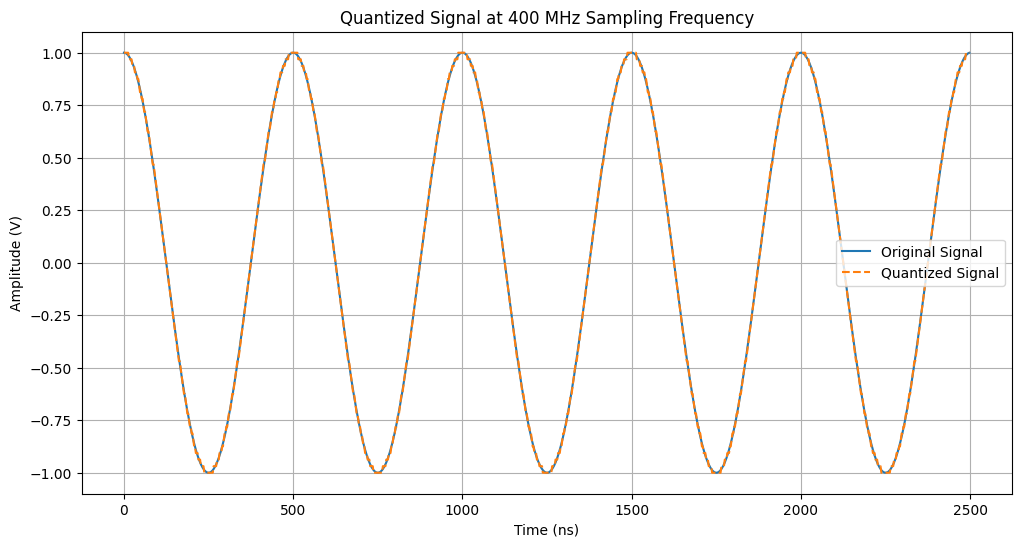

In [ ]:
Fs_new = 400e6  # new sampling frequency
num_periods = 5  # number of periods to simulate

t_new = np.arange(0, num_periods / F, 1 / Fs_new)

x_new = A * np.cos(2 * np.pi * F * t_new)

num_bits = 6
quantization_levels = 2**num_bits

x_quantized = np.round(x_new * (quantization_levels / 2)) / (quantization_levels / 2)

# Plot the quantized signal
plt.figure(figsize=(12, 6))
plt.plot(t_new[:1000] * 1e9, x_new[:1000], label='Original Signal')
plt.plot(t_new[:1000] * 1e9, x_quantized[:1000], label='Quantized Signal', linestyle='--')
plt.title('Quantized Signal at 400 MHz Sampling Frequency')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)
plt.show()

### (b) Find an incommensurate sampling frequency
- Choose a sampling frequency larger than the Nyquist rate.
- Plot the PSD of the new samples.
- Calculate the SNR from the figure.

### (c) Repeat (a) using a 12-bit quantizer
- Can you prove from simulations that SNR ~ 6N (where N is the number of bits used) for both cases, N = 6 and N = 12?

### (d) Apply a Hanning window
- Repeat (c) with a Hanning window.
- What is the SNR?
- Make your own conclusions.

### (e) Add noise and analyze SNR
- Add noise such that the signal SNR is 38 dB.
- Repeat (c) and (d).
- What are the SNRs?
- Provide conclusions.

**HINT:** Write a Python function using `numpy.round` to perform quantization on your waveform.